# Implementing quantum stochastic differential equations on a quantum computer

Original authors of paper: Gé Vissers & Luc Bouten \
Link to paper https://link.springer.com/article/10.1007/s11128-019-2272-z

"$\kappa$ is the decay rate, $\omega$ is the transition frequency of the two-level atom and $\Omega$ is the frequency of the Rabi oscillations" ... " This time interval is divided into $N$ equal sub-intervals of length $T/N$. We define $\lambda := \sqrt{T/N}$, i.e., there are $N$ time slices of length $\lambda^2$."

__Note__: maybe not enough details in paper to reproduce results.

```
!pip install --upgrade qiskit
!pip install qiskit-terra[qasm3-import]
```

In [1]:
import warnings
warnings.simplefilter('ignore')
import qiskit.qasm3
from numpy import sqrt, log, exp, sin, cos

from tqdm import trange
import json

# import packages
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info import Statevector
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

# IBMQ
from qiskit import IBMQ

# Figure 1

Master equation 9: $\kappa=1, \omega=1, \Omega=12, \lambda^2=0.01$

Operators $M^+, M^0$ are given by eq 8.

In [200]:
# main parameters
kappa = 1
omega = 0
Omega = 12
lbd = sqrt(0.01)

def getM0(): # eq 8 M^0
    mat = np.zeros((2,2), dtype=complex)
    #mat[0,0] = exp(-1j*omega*lbd**2) * cos(sqrt(kappa)*lbd) * cos(Omega*lbd**2/2)-1
    #mat[0,1] = -exp(-1j*omega*lbd**2) * cos(sqrt(kappa)*lbd) * sin(Omega*lbd**2/2)
    mat[0,0] = cos(sqrt(kappa)*lbd) * cos(Omega*lbd**2/2)-1
    mat[0,1] = -cos(sqrt(kappa)*lbd) * sin(Omega*lbd**2/2)
    mat[1,0] = sin(Omega*lbd**2/2)
    mat[1,1] = cos(Omega*lbd**2/2)-1
    mat = mat/lbd**2
    return mat

def getMp(): # eq 8 M^+
    mat = np.zeros((2,2), dtype=complex)
    #mat[1,0] = exp(-1j*omega*lbd**2) * sin(sqrt(kappa)*lbd) * cos(Omega*lbd**2/2)
    #mat[1,1] = -exp(-1j*omega*lbd**2) * sin(sqrt(kappa)*lbd) * sin(Omega*lbd**2/2)
    mat[1,0] = sin(sqrt(kappa)*lbd) * cos(Omega*lbd**2/2)
    mat[1,1] = -sin(sqrt(kappa)*lbd) * sin(Omega*lbd**2/2)
    mat = mat/lbd
    return mat

M0 = getMp(); M0c = np.transpose(np.conjugate(M0)); #np.conjugate(M0);
Mp = getMp(); Mpc = np.transpose(np.conjugate(Mp)); #np.conjugate(Mp);
# evolution operator
def Lindblad(rho):
    return np.matmul(Mpc,np.matmul(rho,Mp)) * lbd**2 * np.matmul(M0c,np.matmul(rho,M0)) + np.matmul(M0, rho) + np.matmul(rho, M0c)
    #return np.matmul(Mp,np.matmul(rho,Mpc)) * lbd**2 * np.matmul(M0,np.matmul(rho,M0c)) + np.matmul(M0, rho) + np.matmul(rho, M0c)

# time parameters
tmax = 1; dt = lbd**2; N = int(tmax/dt)
tlst = np.linspace(0,1,N)

# initial condition
rho0 = np.zeros((2,2), dtype=complex); rho0[1,1] = 1.0;
# state matrix density
rho = np.copy(rho0)

# Pauli matrices
sigmax = np.zeros((2,2), dtype=complex); sigmax[0,1] = 1; sigmax[1,0] = 1;
sigmay = np.zeros((2,2), dtype=complex); sigmay[0,1] = -1j; sigmay[1,0] = 1j;
sigmaz = np.zeros((2,2), dtype=complex); sigmaz[0,0] = 1; sigmaz[1,1] = -1; #print(sigmay)

sigmaxt = np.zeros(N); sigmayt = np.zeros_like(sigmaxt); sigmazt = np.zeros_like(sigmaxt)
for t in trange(N):
    sigmaxt[t] = np.trace(np.matmul(rho, sigmax))
    sigmayt[t] = np.trace(np.matmul(rho, sigmay))
    sigmazt[t] = np.trace(np.matmul(rho, sigmaz))
    rho = rho + Lindblad(rho) * dt

100%|█████████████████████████████████████████| 99/99 [00:00<00:00, 9136.11it/s]


In [201]:
print('unitary simulation')
# create quantum register (bundle of qubits)
lbd = sqrt(0.01)
qreg_q = QuantumRegister(2, 'q')
circuit = QuantumCircuit(qreg_q)
# add individual gates (but switch order)
circuit.ry(Omega*lbd**2, qreg_q[1])
circuit.rz(omega*lbd**2, qreg_q[1])
circuit.cx(qreg_q[1],qreg_q[0])
circuit.cry(2*sqrt(kappa)*lbd, qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[1],qreg_q[0])
# get unitary
job = qiskit.execute(circuit, backend, shots=1)
result = job.result()
circuitU = result.get_unitary(circuit,8)
# use unitary in simulation
Uop = np.array(circuitU, dtype=complex)
psi0 = np.array([0,0,0,1], dtype=complex)
psi = np.copy(psi0)
Id = np.eye(2, dtype=complex)
sigmaxtU = np.zeros(N, dtype=complex); sigmaytU = np.zeros_like(sigmaxtU); sigmaztU = np.zeros_like(sigmaxtU)
for t in trange(N):
    sigmaxtU[t] = np.matmul(np.conjugate(psi), np.matmul(np.kron(Id, sigmax), psi))
    sigmaytU[t] = np.matmul(np.conjugate(psi), np.matmul(np.kron(Id, sigmay), psi))
    sigmaztU[t] = np.matmul(np.conjugate(psi), np.matmul(np.kron(Id, sigmaz), psi))
    psi = np.matmul(Uop, psi)

unitary simulation


100%|█████████████████████████████████████████| 99/99 [00:00<00:00, 5087.56it/s]


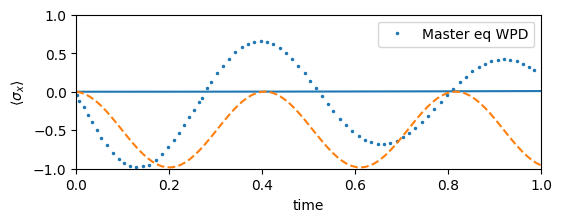

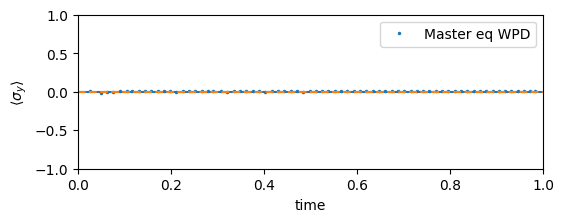

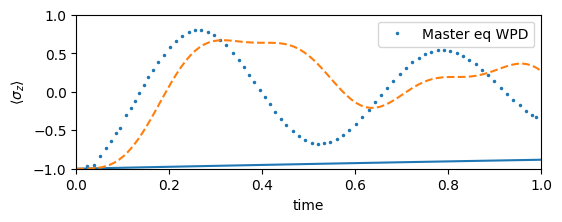

In [202]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,2))
f = open('dataWPD/fig1upper/wpd.json')
data = json.load(f)
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'.', markersize=3, color='tab:blue', label='Master eq WPD')
plt.plot(tlst, sigmaxt)
plt.plot(tlst, sigmaxtU, '--')
plt.xlabel(r'time')
plt.ylabel(r'$\langle \sigma_x \rangle$')
plt.legend()
plt.xlim([0,1])
plt.ylim([-1,1])
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,2))
f = open('dataWPD/fig1lower/wpd.json')
data = json.load(f)
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'.', markersize=3, color='tab:blue', label='Master eq WPD')
plt.plot(tlst, sigmayt)
plt.plot(tlst, sigmaytU, '--')
plt.xlabel(r'time')
plt.ylabel(r'$\langle \sigma_y \rangle$')
plt.legend()
plt.xlim([0,1])
plt.ylim([-1,1])
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,2))
f = open('dataWPD/fig1c/wpd.json')
data = json.load(f)
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'.', markersize=3, color='tab:blue', label='Master eq WPD')
plt.plot(tlst, sigmazt)
plt.plot(tlst, sigmaztU, '--')
plt.xlabel(r'time')
plt.ylabel(r'$\langle \sigma_z \rangle$')
plt.legend()
plt.xlim([0,1])
plt.ylim([-1,1])
plt.show()

circuit from qasm


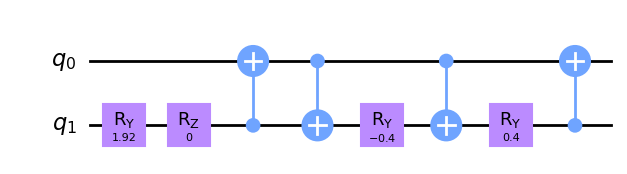

In [177]:
print('circuit from qasm')
qreg_q = QuantumRegister(2, 'q')
circuitVissers = QuantumCircuit(qreg_q)
circuitVissers.ry(1.92, qreg_q[1])
circuitVissers.rz(0.0, qreg_q[1])
circuitVissers.cx(qreg_q[1],qreg_q[0])
circuitVissers.cx(qreg_q[0],qreg_q[1])
circuitVissers.ry(-0.4, qreg_q[1])
circuitVissers.cx(qreg_q[0],qreg_q[1])
circuitVissers.ry(0.4, qreg_q[1])
circuitVissers.cx(qreg_q[1],qreg_q[0])
circuitVissers.draw("mpl")

#circuitVissers = qiskit.circuit.QuantumCircuit.from_qasm_file("qasm_vissersNoMeasure.txt")
#circuitVissers.draw("mpl")

circuit from §3 switch order


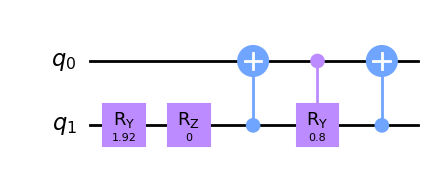

In [178]:
print('circuit from §3 switch order')
# create quantum register (bundle of qubits)
lbd = sqrt(0.16)
qreg_q = QuantumRegister(2, 'q')
circuit = QuantumCircuit(qreg_q)
# add individual gates (but switch order)
circuit.ry(Omega*lbd**2, qreg_q[1])
circuit.rz(omega*lbd**2, qreg_q[1])
circuit.cx(qreg_q[1],qreg_q[0])
circuit.cry(2*sqrt(kappa)*lbd, qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[1],qreg_q[0])
# draw
circuit.draw('mpl')

In [179]:
backend = Aer.get_backend('unitary_simulator')

job = qiskit.execute(circuitVissers, backend, shots=1)
result = job.result()
circuitVissersU = result.get_unitary(circuitVissers,3)

job = qiskit.execute(circuit, backend, shots=1)
result = job.result()
circuitU = result.get_unitary(circuit,3)

# should give the same result
print(circuitU)
print(circuitVissersU)

Operator([[ 0.574+0.j,  0.   +0.j, -0.819+0.j,  0.   +0.j],
          [-0.319+0.j,  0.528+0.j, -0.223+0.j, -0.755+0.j],
          [ 0.755+0.j,  0.223+0.j,  0.528+0.j, -0.319+0.j],
          [-0.   +0.j,  0.819+0.j,  0.   +0.j,  0.574+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))
Operator([[ 0.574+0.j,  0.   +0.j, -0.819+0.j, -0.   +0.j],
          [-0.319+0.j,  0.528+0.j, -0.223+0.j, -0.755+0.j],
          [ 0.755+0.j,  0.223+0.j,  0.528+0.j, -0.319+0.j],
          [ 0.   +0.j,  0.819+0.j,  0.   +0.j,  0.574+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


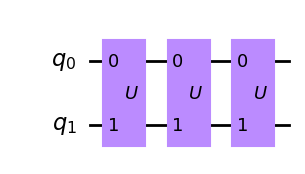

In [180]:
## Create circuit
# we can convert the previous circuit to a custom gate
U_vis = circuit.to_gate()
U_vis.label = "$U$"
# we can then add the new gate to a circuit many times
qc_vis = QuantumCircuit(2)
for i in range(3):
    qc_vis.append(U_vis,[0,1])
qc_vis.draw('mpl')